In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os, time, re, random, time
import matplotlib as mpl
from scipy import stats

import cobra
from cobra import Model, Reaction, Metabolite, flux_analysis

import warnings
warnings.filterwarnings('ignore')

import gurobipy
import optlang.gurobi_interface as grb

print(cobra.__version__)

print(gurobipy.Model())
cobra.solver = 'gurobi'

0.29.1
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-16
<gurobi.Model Continuous instance Unnamed: 0 constrs, 0 vars, Parameter changes: Username=(user-defined)>


In [2]:
# setup
pal4 = sns.color_palette("mako",4)
pal3 = sns.color_palette("mako",3)
pal2 = [sns.color_palette("mako",4)[3],sns.color_palette("mako",4)[0]]
pal22 = [sns.color_palette("mako",4)[0],sns.color_palette("mako",4)[3]]

folder = '../data/'

# functions
def flatten(t):
    return [item for sublist in t for item in sublist]

def fix_strings_list(x):
    return [xx.strip('[').strip(']').strip("'") for xx in list(x.split(', ')) if not pd.isna(x)]

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def linfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(x, y, 1)
    return m * xnew**(k)
    
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)
    

In [3]:
# load 
# met dict
tmp = pd.read_csv(folder+'store_met_dic_12-9-2023.csv',
                  names=['values','keys']).iloc[1:]
met_dic = dict(zip(tmp['keys'].tolist(),tmp['values'].tolist()))

# load df_rxns
df_rxns = pd.read_excel(folder+'curatedPotatoGEM_annotation_table.xlsx')
print(df_rxns.shape)
df_rxns['pws'] = df_rxns.Pathway.str.split('|')
df_rxns2 = df_rxns.dropna(subset=['pws'])
df_rxns2 = df_rxns2.explode('pws')
print(df_rxns2.shape)

# load model
model = cobra.io.read_sbml_model(folder+'curatedPotatoGEM.xml')

co_ratio = model.problem.Constraint(
    model.reactions.RBC_h.flux_expression - model.reactions.RBO_h.flux_expression * (10.7/3.72),
    lb=0,
    ub=0)
model.add_cons_vars(co_ratio)

obj = 'Bio_Stu_leaf'
model.objective = obj

model

(7092, 35)
(3426, 35)


<Model model at 0x2242af5a5d0>

In [4]:
# 2nd met annotations
df_test = pd.read_csv(folder+'2nd_met_annotations_table-15_4_25.tsv', sep='\t')
print(df_test.shape)

# reconstruct string to list 
df_test['products'] = df_test['products'].apply(fix_strings_list)
df_test['product_ids'] = df_test['product_ids'].apply(fix_strings_list)
df_test['last_rxns'] = df_test['last_rxns'].apply(fix_strings_list)

print(df_test.query('type=="precursors"').explode('product_ids').product_ids.unique().shape)
print(df_test.query('type=="2nd"').explode('product_ids').product_ids.unique().shape)
print(df_test.query('type=="precursors"').explode('last_rxns').last_rxns.unique().shape)
print(df_test.query('type=="2nd"').explode('last_rxns').last_rxns.unique().shape)
print(df_test.query('type=="2nd"').explode('last_rxns').query('last_rxns=="nan"').shape) # note

# num pws per type
print(df_test.groupby('type').biocyc_pwy.nunique())

# create last rxns
print(df_test.query('type=="precursors"').explode('last_rxns').last_rxns.unique().shape)
print(df_test.query('type=="2nd"').explode('last_rxns').last_rxns.unique().shape)

df_last = (df_test
           .query('type=="2nd"')
           .explode('last_rxns')
           .query('last_rxns!="nan"')
          )
print(df_last.biocyc_pwy.unique().shape)
print(df_last.last_rxns.unique().shape)


(137, 12)
(29,)
(182,)
(33,)
(199,)
(3, 12)
type
2nd           106
precursors     23
Name: biocyc_pwy, dtype: int64
(33,)
(199,)
(106,)
(198,)


In [5]:
# supp table - num pws, rxns, products
df_test2 = df_test.merge(df_rxns2[['Abbreviation','pws']],
             left_on='biocyc_pwy',right_on='pws',how='left'
             )

table = (df_test.query('type=="2nd"').groupby(['class','subclass'])
         ['biocyc_pwy'].count()
         .rename('Pathways')
         .reset_index()
        )
table['Reactions'] = (df_test2.query('type=="2nd"')
                      .groupby(['class','subclass'])
                      ['Abbreviation'].count()
                      .values
                     )
df_test['product_ids2'] = df_test.product_ids #.str.split(', ')
tmp = df_test.explode('product_ids2')
table['Products'] = (tmp.query('type=="2nd"').groupby(['class','subclass'])
                     .product_ids2.count().values
                    )
table.set_index(['class','subclass'])


Pathways  Reactions  Products
class                       subclass                                          
alkaloids                   alkaloids                   6         37        11
hormones                    ABA                         2         11         3
                            Auxins                      2          4         2
                            Brassinosteroids            2         46         2
                            Cytokinins                  5         27        11
                            Eth                         1          3         1
                            Gibberellins                4         25         9
                            JA                          2         26         5
                            SA                          6         20         6
other                       FA derivatives              3         18         8
                            nitrogen-containing         2         12         5
                            sugar alcohols              6         38         7
phenylpropanoid derivatives cinnamates                  5         17         7
                            coumarins                   4         16         4
                            flavonoids                 21        116        40
                            lignan                      2         13         3
                            lignin                      1          2         1
                            other                       3          9         3
                            phen. prec.                 6        138        10
terpenoids                  diterpenoid                 3          7         3
                            monoterpenoid               7         22        13
                            sesquiterpenoid             5         23        16
                            tetraterpenoid              7         21         9
                            triterpenoid                5         14         8
toxins                      phytoalexins                2          9         4

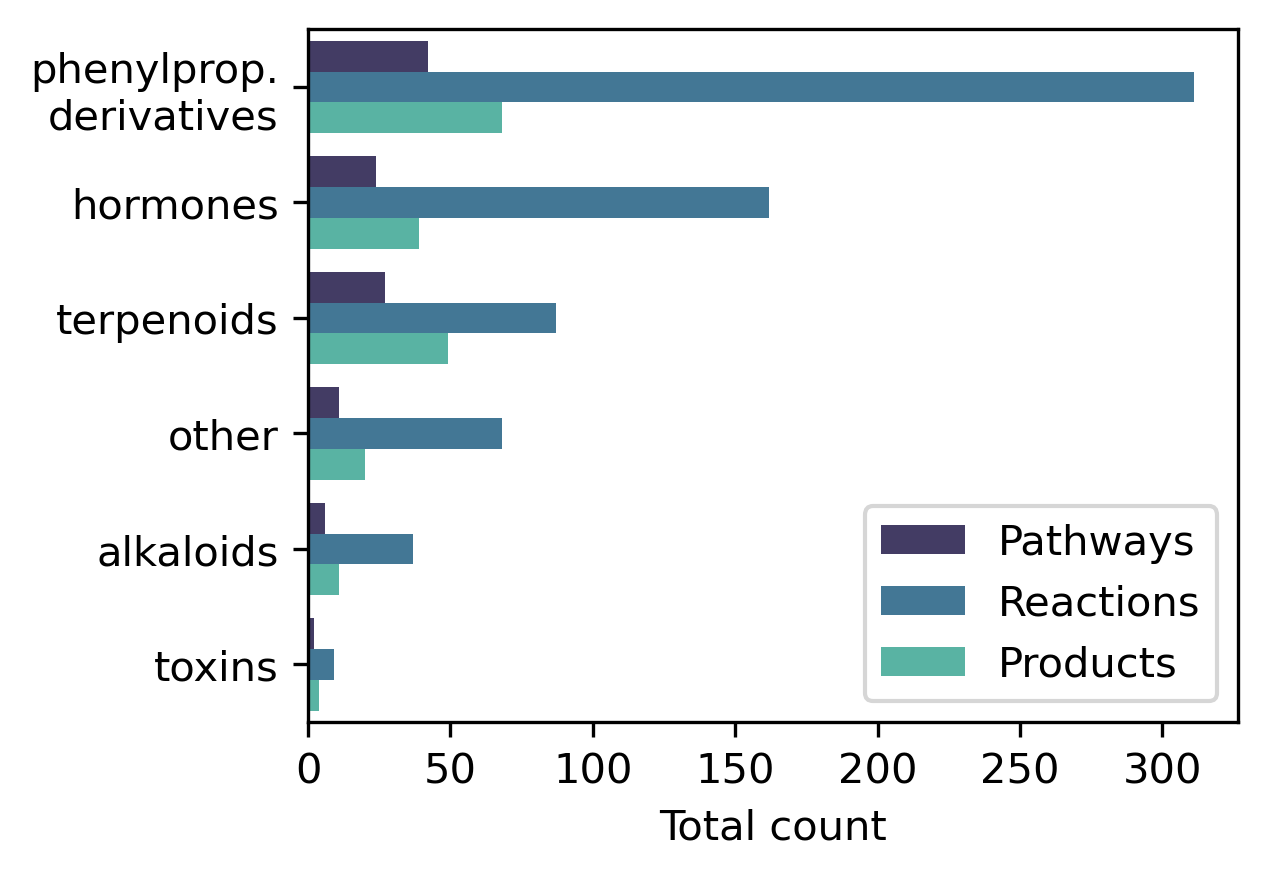

In [6]:
# figure 2A
tmp = (table.groupby('class')
            [['Pathways','Reactions','Products']]
            .sum().stack().reset_index()
       .replace({'class':{'phenylpropanoid derivatives':'phenylprop.\nderivatives'}})
)
tmp
order = (tmp.query('level_1=="Reactions"')
       .sort_values(by=0,ascending=False)
       ['class'].tolist()
      )

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.barplot(data=tmp,
            x=0,y='class',hue='level_1',
            palette=pal3,
            order=order
           )
plt.ylabel('')
plt.xlabel('Total count')
plt.legend(title='')
plt.show()


In [7]:
# producing single components

def test_single_production_ld(model,biomass,
                             figsize=(15,1.4),
                             filename=''
                             ):
    dic_list = []
    results = []
    for idx,row in biomass.iterrows():
        dic_list.append({row.id:
            -1000*row.mmolgdw,
                        })
                         
        rxn_leaf = Reaction('Test_production_'+row.id)
        rxn_leaf.name = 'Test_production: '+row.compound
        rxn_leaf.subsystem = ''
        rxn_leaf.reversibility = False
        rxn_leaf.lower_bound = 0.
        rxn_leaf.upper_bound = 1000.0 

        # add rxn to model
        model.add_reactions([rxn_leaf])
        rxn_leaf.add_metabolites(dic_list[-1])

        # set model objective
        model.objective = 'Test_production_'+row.id

        # check basic fba
        solution = model.optimize()
        tmp = solution.to_frame()
        results.append(solution)

        # remove rxn from model
        model.reactions[-1].remove_from_model()

    # add results to frame
    biomass['flux'] = [x.objective_value for x in results]
    biomass['num_rxns'] = [x.to_frame().query('fluxes>0').shape[0] for x in results]

    # plot
    mpl.rcParams['figure.dpi'] = 300
    plt.figure(figsize=figsize)
    sns.barplot(data=biomass,
               x='compound',y='flux',
                palette=['grey']
               )
    plt.xticks(rotation=45,ha='right')
    plt.yscale('log')
    plt.ylabel('Predicted flux,\nmmol/gDW h')
    plt.xlabel('')
    plt.tight_layout()
    
    if len(filename)>0:
        plt.savefig(filename+'_flux'+'.png',bbox_inches='tight')
    
    plt.show()
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(data=biomass,
               x='compound',y='num_rxns',
               palette=['grey']
                    )
    plt.xticks(rotation=45,ha='right')
    plt.ylabel('Num. reactions\ninvolved')
    plt.tight_layout()

    if len(filename)>0:
        plt.savefig(filename+'_rxns'+'.png',bbox_inches='tight')
    
    plt.show()
    
    return biomass, results

(182, 6)


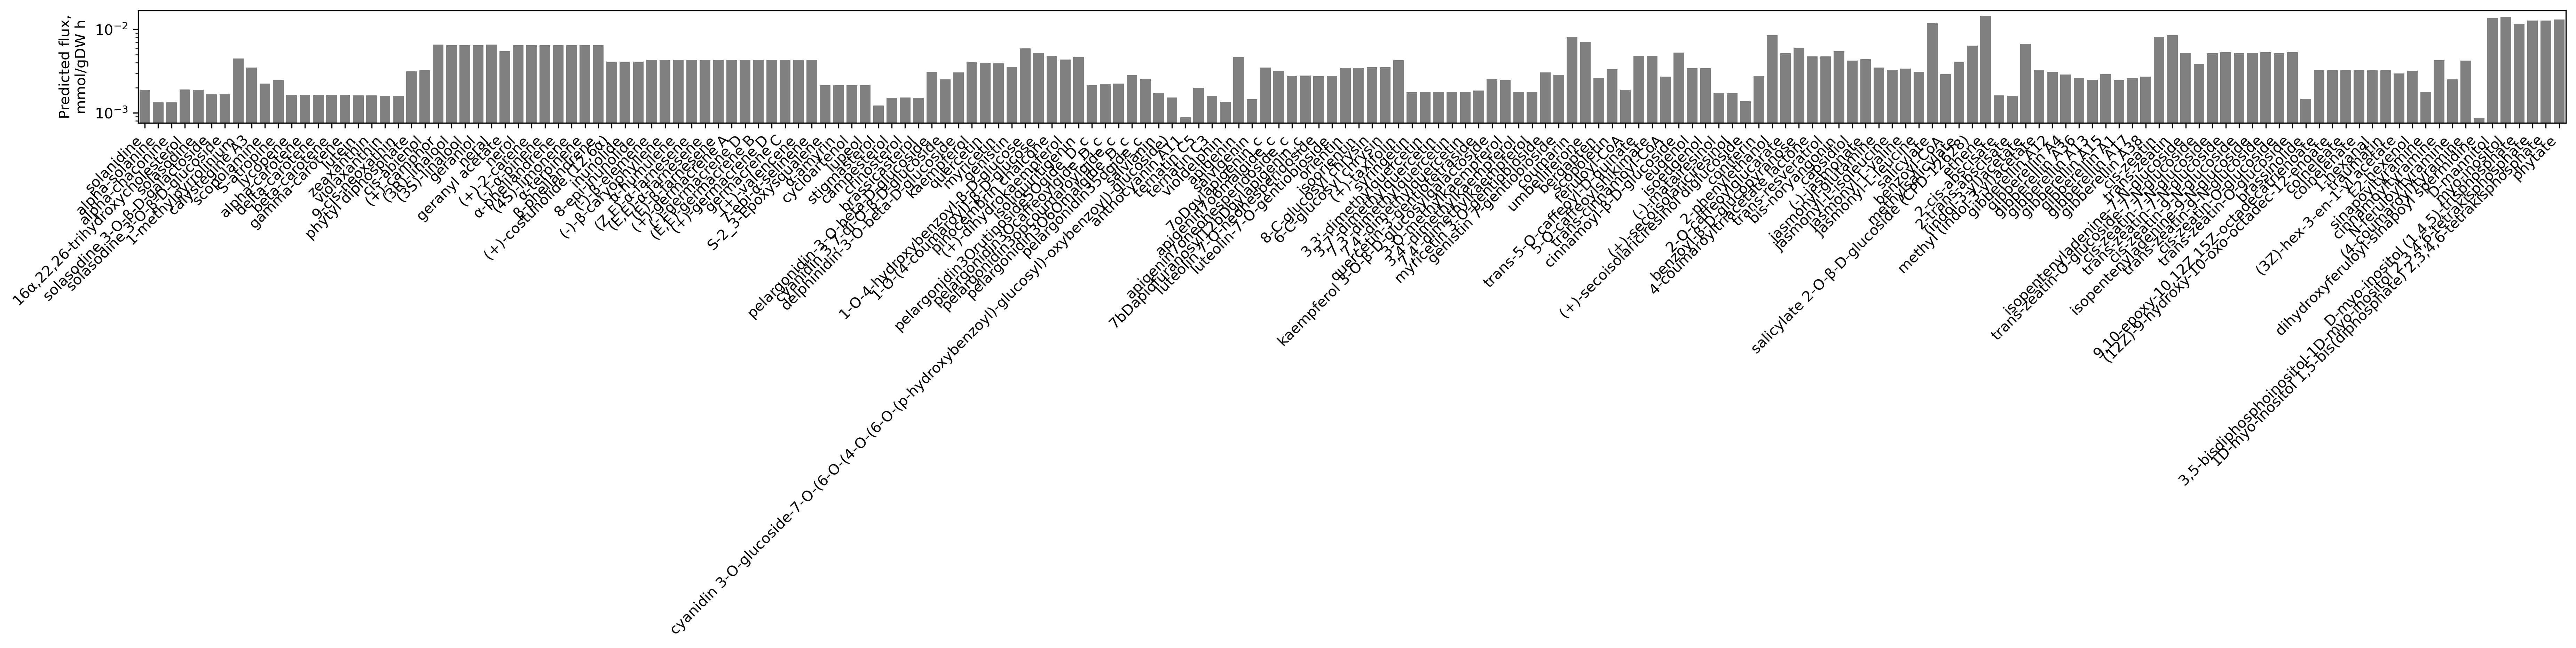

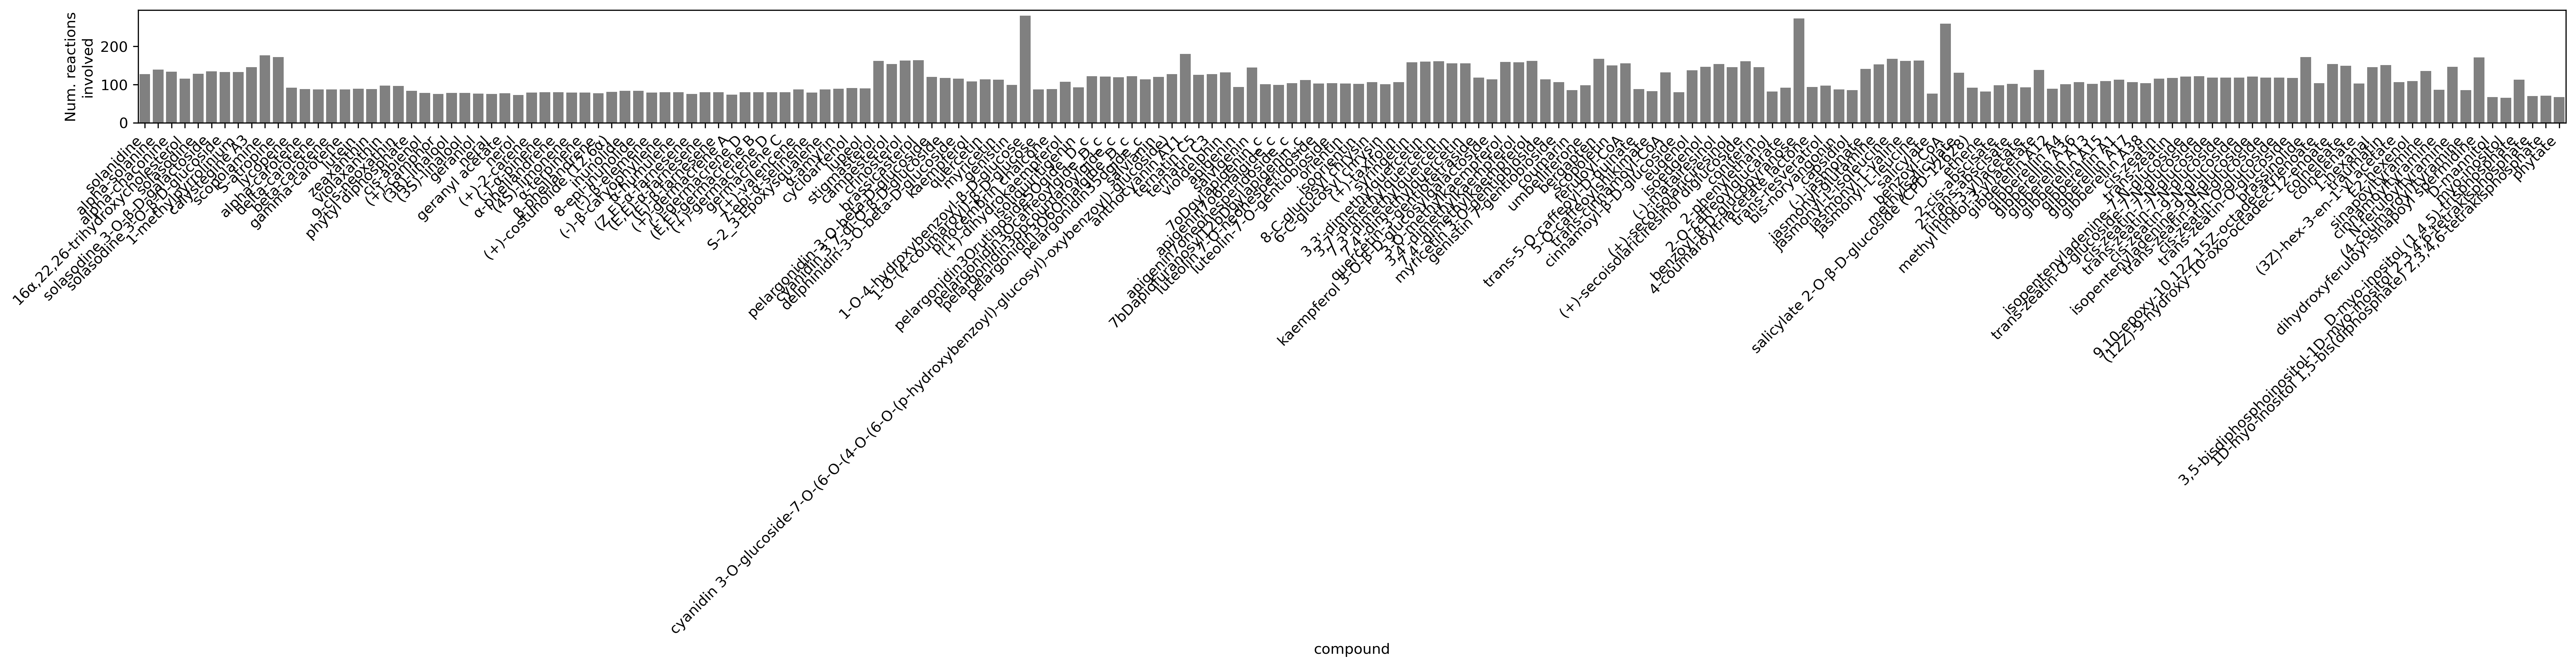

In [8]:
# products
tmp = pd.read_csv(folder+'2nd_met_list-incl_prec-15_4_25.tsv',sep='\t').query('type=="2nd"')
tmp['mmolgdw'] = 1
print(tmp.shape)

# run
df_prod, res_prod = test_single_production_ld(model,tmp,(30,1.4),'2nd_production')#,phototroph,heterotroph,(30,1.4))

(101, 9)


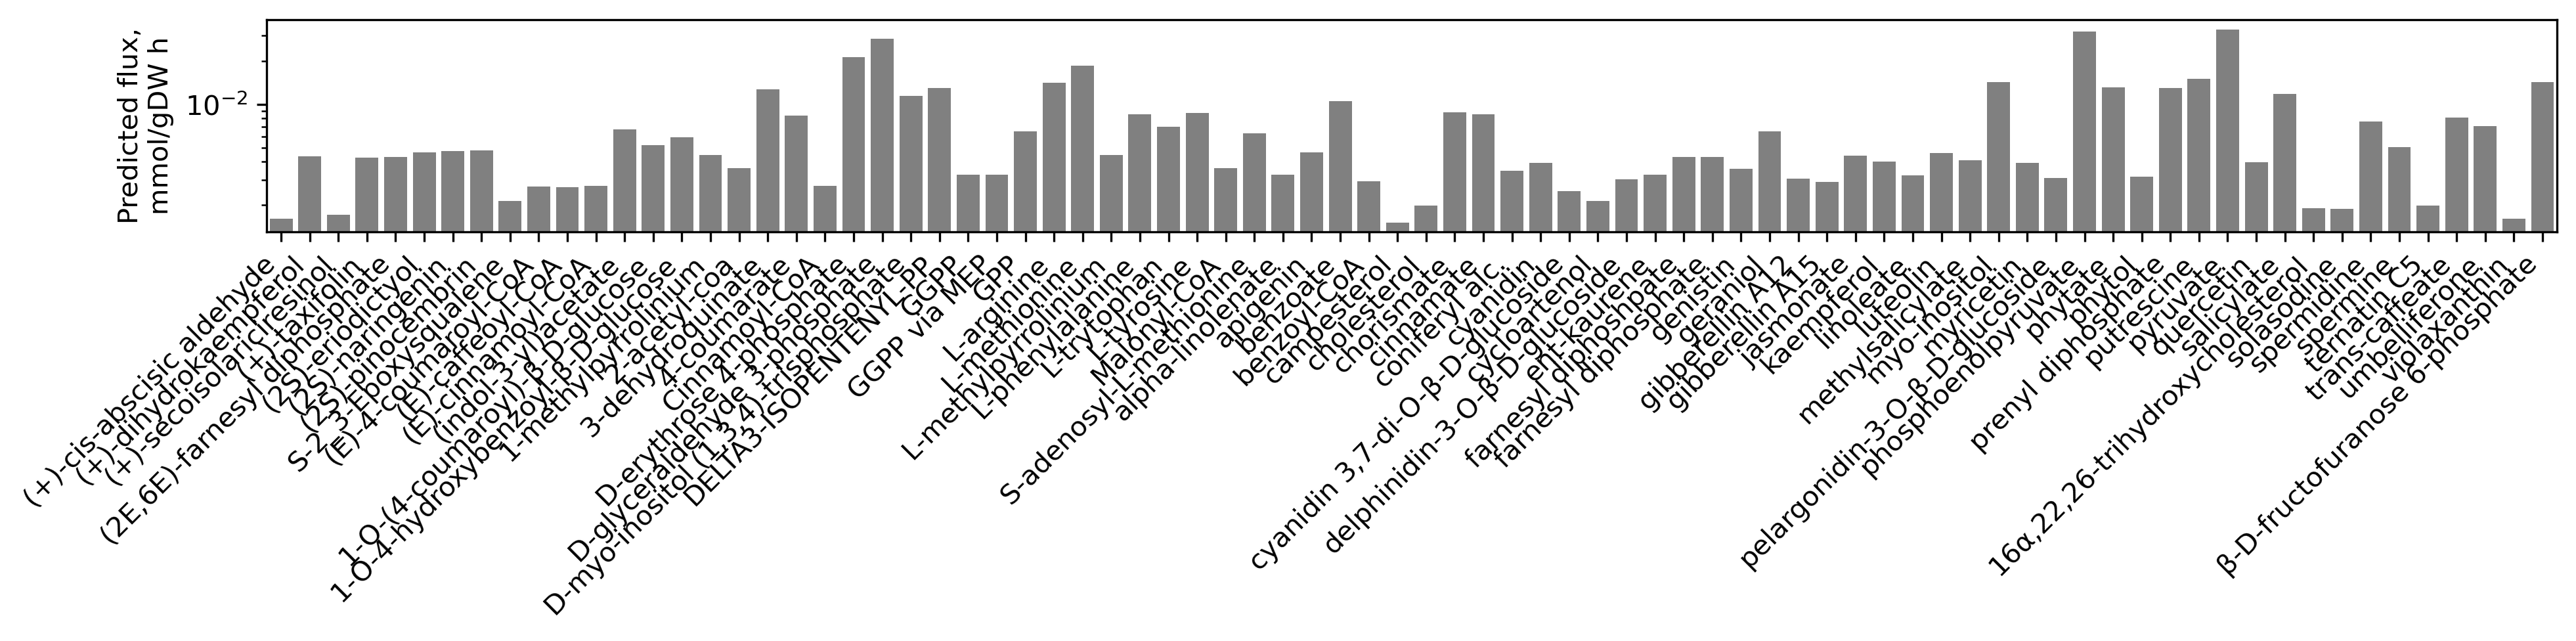

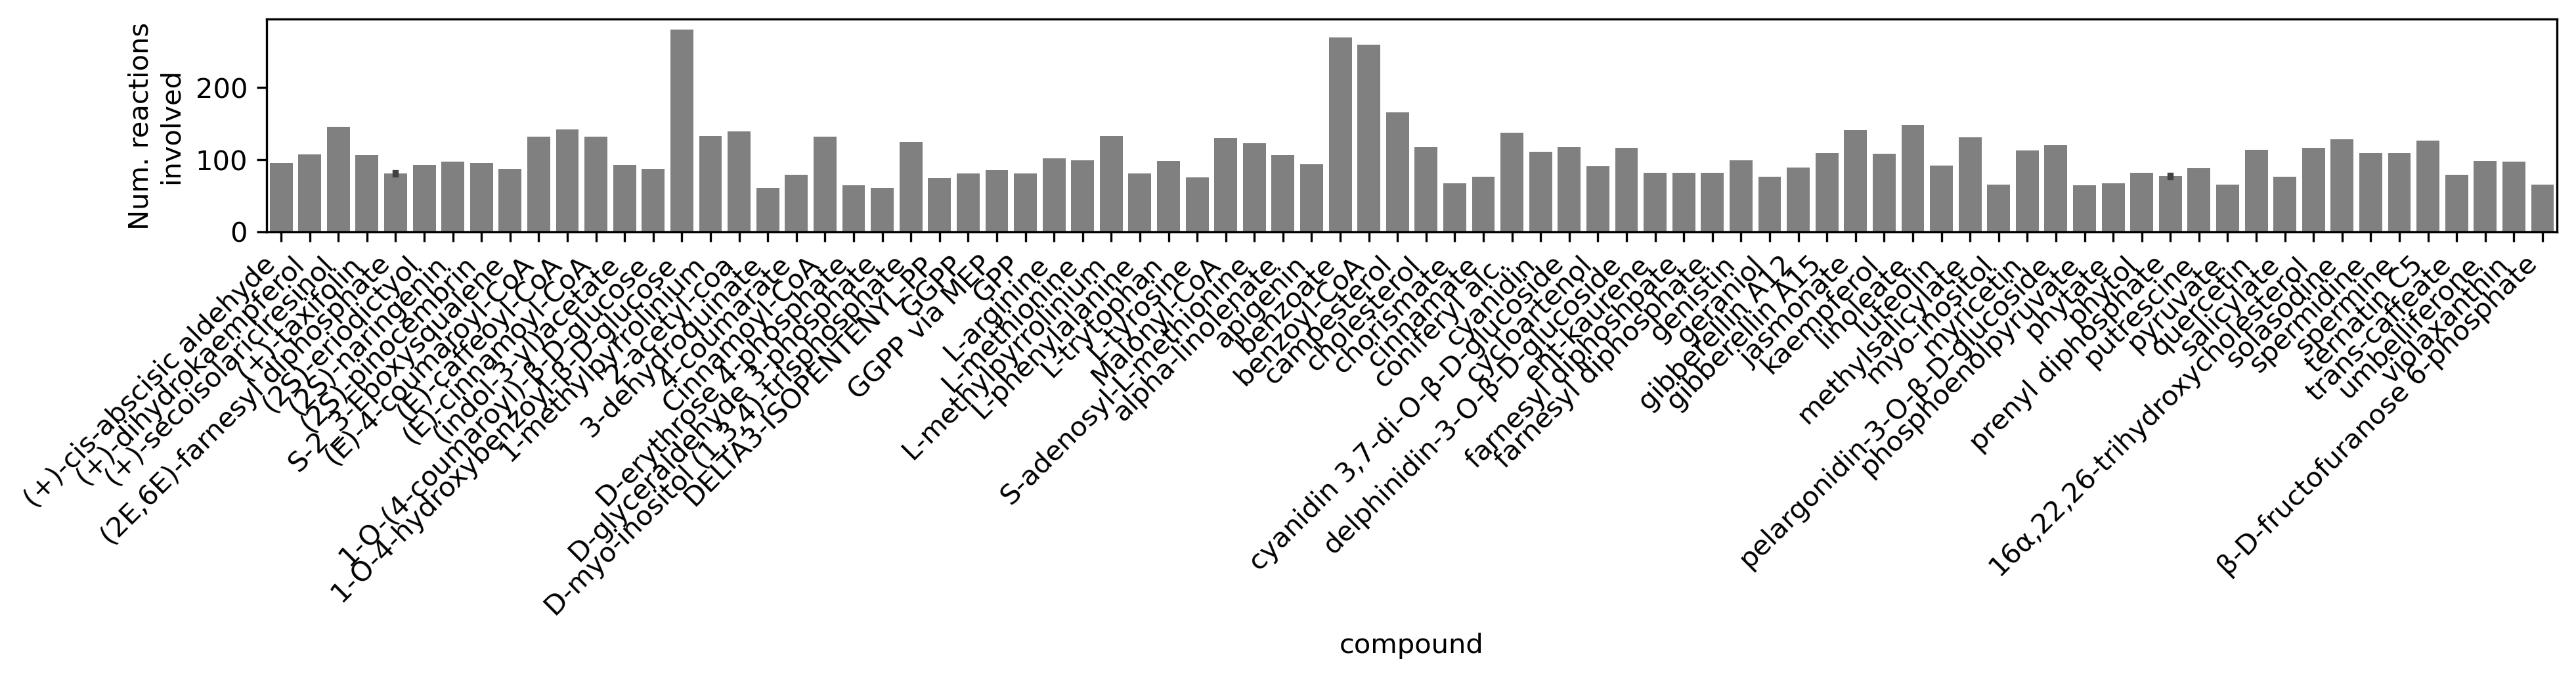

In [9]:
# test precursors
tmp = pd.read_csv(folder+'2nd_met_precursors_list-15_4_25.tsv',sep='\t')
tmp['id'] = tmp.precursor_ids
tmp['compound'] = tmp.precursors
tmp['mmolgdw'] = 1
print(tmp.shape)

# run
df_prec, res_prec = test_single_production_ld(model,tmp) #,phototroph,heterotroph)


(2189, 14)


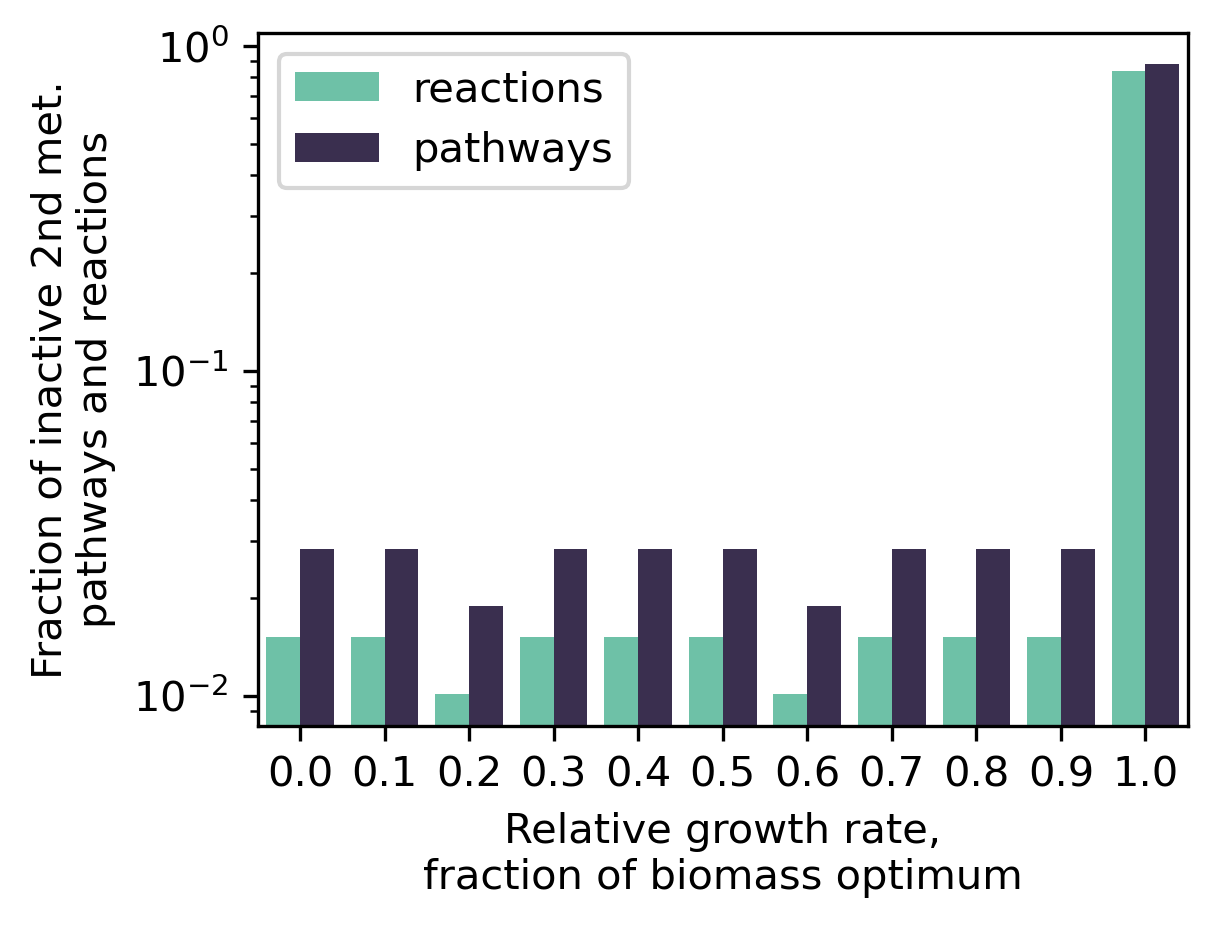

In [10]:
# fig 2d

# coupling analysis
# laod FVA results at fopt 0 to 1
df_fva_last = pd.read_csv(folder+'df_fva_last_fopt_0-1_model_25-04-16.tsv',sep='\t')
print(df_fva_last.shape)

# set min range
tol = 1e-6
df_fva_last.loc[abs(df_fva_last.maximum)<tol,'maximum'] = 0.0

# count values
tmp = []
for x in df_fva_last.fopt.unique():
    tmp.append([x,
                df_fva_last.query('fopt==@x').query('maximum<@tol').last_rxns.unique().shape[0],
                df_fva_last.query('fopt==@x').query('maximum<@tol').biocyc_pwy.unique().shape[0],
                df_fva_last.query('fopt==@x').query('maximum<@tol').last_rxns.unique(),
                df_fva_last.query('fopt==@x').query('maximum<@tol').biocyc_pwy.unique(),
                len(set(df_fva_last.query('fopt==@x').query('maximum<@tol').last_rxns.unique())
                .intersection(set(df_fva_last.query('fopt==1.0').query('maximum<@tol').last_rxns.unique()))
                   ),
                len(set(df_fva_last.query('fopt==@x').query('maximum<@tol').biocyc_pwy.unique())
                .intersection(set(df_fva_last.query('fopt==1.0').query('maximum<@tol').biocyc_pwy.unique()))
                   )
               ])
   
df_plot = pd.DataFrame(tmp,columns=['fopt','max0_rxns','max0_pws',
                                    'last_rxns','biocyc_pwy',
                                    'overlap_rxns_1','overlap_pws_1'
                                   ])
df_plot['inactive_rxns'] = df_plot.max0_rxns.divide(df_last.last_rxns.unique().shape[0])
df_plot['inactive_pws'] = df_plot.max0_pws.divide(df_last.biocyc_pwy.unique().shape[0])

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.barplot(data=df_plot
            .rename(columns={'inactive_rxns':'reactions',
                            'inactive_pws':'pathways'})
            .melt(id_vars='fopt',value_vars=['reactions','pathways']),
            x='fopt',y='value',hue='variable',
            palette=pal2
           )
plt.ylabel('Fraction of inactive 2nd met.\npathways and reactions')
plt.xlabel('Relative growth rate,\nfraction of biomass optimum')
plt.yscale('log')
plt.legend(title='')
plt.show()


In [11]:
# percent and num inactive
print(df_plot.query('fopt==1').inactive_pws.values[0])
print((1-df_plot.query('fopt<1').inactive_pws).min())
print((df_fva_last.biocyc_pwy.unique().shape[0]-df_plot.max0_pws).max()-1)
print((df_fva_last.last_rxns.unique().shape[0]-df_plot.max0_rxns).max()-1)

# check active at fopt=1
print(df_fva_last.query('fopt==1').query('maximum>@tol').last_rxns.nunique())
print(df_fva_last.query('fopt==1').query('maximum>@tol').maximum.max())

# fopt=0.6
print(1-df_plot.query('fopt==0.6').inactive_pws.values[0])
print(1-df_plot.query('fopt==0.6').inactive_rxns.values[0])

# count pathways fopt=0.6
allp = set(df_last.biocyc_pwy.unique().tolist())
print(len(allp))
inactive = set(df_plot.query('fopt==0.6').biocyc_pwy.values[0].tolist())
print(len(inactive))
coupled = allp-inactive
print(len(coupled))


0.8773584905660378
0.9716981132075472
103
194
31
0.2855110433786826
0.9811320754716981
0.98989898989899
106
2
104


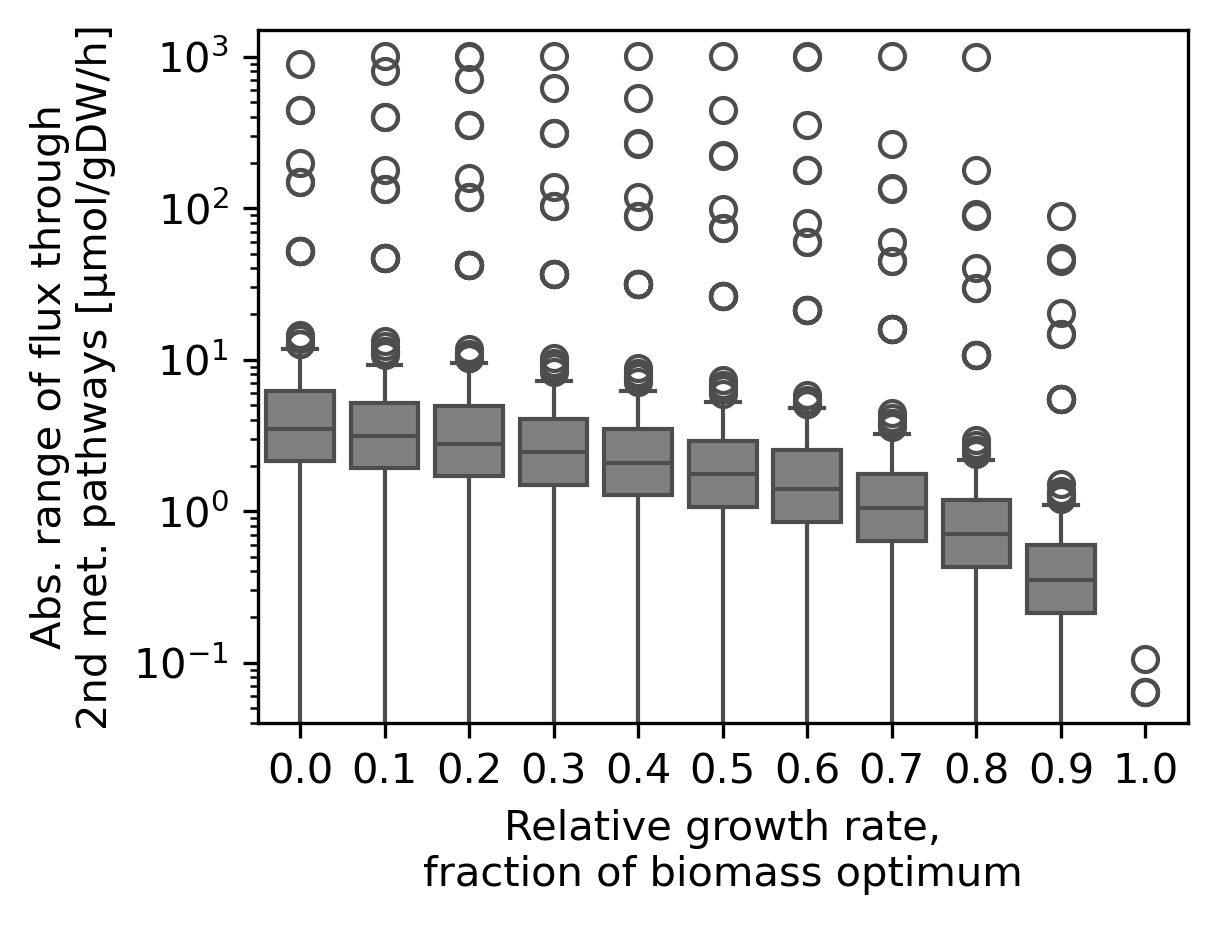

In [12]:
# fig 2c
# plot ranges increase with decreasing fopt

# define ranger and range_diff variables
df_fva_last['range'] = df_fva_last[['minimum','maximum']].values.tolist()
df_fva_last['range_diff'] = df_fva_last['range'].apply(lambda x: x[1]-x[0])

# plot ranges increase with decreasing fopt
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.boxplot(data=df_fva_last,
            x='fopt',y='range_diff',
           color='gray')
plt.yscale('log')
plt.ylim(4e-2,1.5e3)
plt.xlabel('Relative growth rate,\nfraction of biomass optimum')
plt.ylabel('Abs. range of flux through\n2nd met. pathways [μmol/gDW/h]')
plt.show()


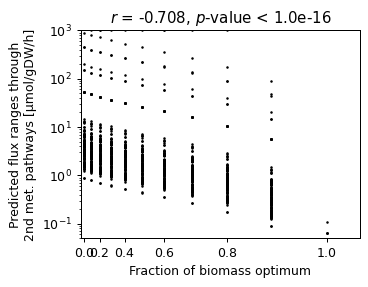

In [13]:
# plot correlation
from functools import partial

def pfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.power(y,10), 1)
    return np.exp(m) * xnew**(k)

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))
x = df_fva_last.fopt.values
y = df_fva_last.range_diff.values

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
rvalue, pvalue = stats.spearmanr(df_fva_last.fopt.apply(np.log).values,np.power(df_fva_last.range_diff.values,10))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.yscale('log')
plt.xscale('function', functions=(partial(np.power, 10.0), np.log10))
plt.ylim(5e-2,1e3)
plt.xlabel('Fraction of biomass optimum')
plt.ylabel('Predicted flux ranges through\n2nd met. pathways [μmol/gDW/h]')
plt.title('$r$ = '+str("%.3f" % rvalue)+', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
plt.show()


Text(0.5, 1.0, '$r$ = -1.000, $p$-value < 1.0e-16')

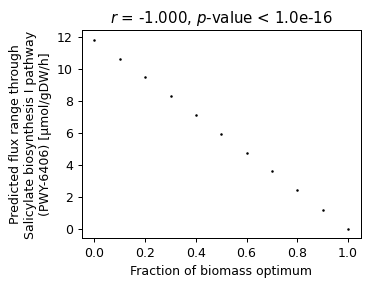

In [14]:
# example coupled reaction
rxn = "SALSYN"
x = df_fva_last.query('last_rxns==@rxn').fopt.values
y = df_fva_last.query('last_rxns==@rxn').range_diff.values

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
rvalue, pvalue = stats.spearmanr(x,y)
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.xlabel('Fraction of biomass optimum')
plt.ylabel('Predicted flux range through\nSalicylate biosynthesis I pathway\n(PWY-6406) [μmol/gDW/h]')

plt.title('$r$ = '+str("%.3f" % rvalue)+', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))


(2189, 16) (2167, 16)


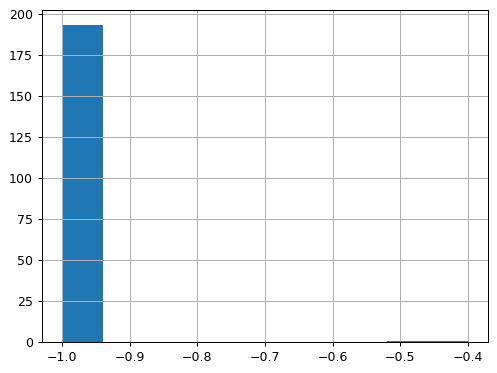

2
0.9897435897435898
0.0
-1.0


In [15]:
# compute correlations per reaction/pwy
tmp = list(set(flatten(df_test.query('biocyc_pwy.isin(@coupled)').last_rxns.tolist())))
print(df_fva_last.shape,df_fva_last.query('last_rxns.isin(@tmp)').shape)

corr_coef = stats.spearmanr
df_corr = (df_fva_last
           .query('last_rxns.isin(@tmp)')
           .groupby('last_rxns')
           .apply(lambda x: corr_coef(x.fopt,x.maximum)[0])
           .rename('r')
           .reset_index()
          )
df_corr['pval'] = (df_fva_last
                   .query('last_rxns.isin(@tmp)')
                   .groupby('last_rxns')
                   .apply(lambda x: corr_coef(x.fopt,x.maximum)[1])
                   .values
                  )
# quick hist
df_corr.dropna().r.hist()
plt.show()

print((df_corr.r>-1).sum())
print(df_corr.dropna().query('pval<0.05').shape[0]/
      df_corr.shape[0])

# what is the highest pval of corr to report
print(df_corr.dropna().query('pval<0.05').pval.max())
print(df_corr.dropna().query('pval<0.05').r.max())

(0, 2)
(194, 2)
(0, 2)
(1, 2)
2


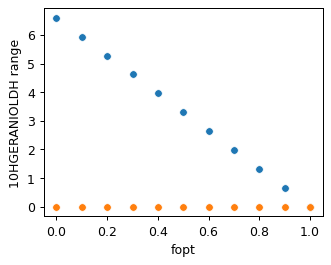

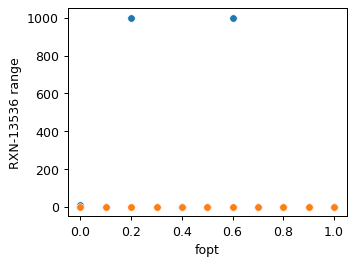

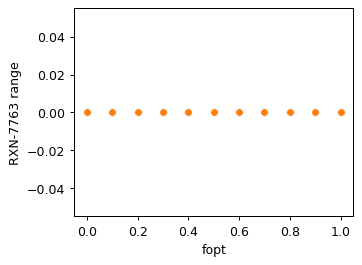

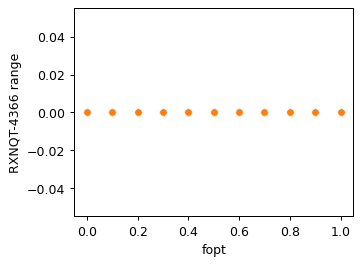

In [16]:
# examples of nonmonotonic and inactive reactions
tmp = (df_fva_last.groupby('last_rxns')
           .apply(lambda x: x.query('fopt==0.7').maximum.values[0]/ 
                         x.query('fopt==0.6').maximum.values[0])
 .rename('direction')
 .reset_index()
)

print(tmp.query('direction==1').shape)
print(tmp.query('direction<1').query('direction>0').shape)
print(tmp.query('direction>1').shape)
print(tmp.query('direction==0').shape)
print(tmp.direction.isnull().sum())

# plot single coupled
rxn = tmp.query('direction<1').last_rxns.unique()[0]
plt.figure(figsize=(4,3))
sns.scatterplot(data=df_fva_last.query('last_rxns==@rxn'),
            y='maximum',x='fopt')
sns.scatterplot(data=df_fva_last.query('last_rxns==@rxn'),
            y='minimum',x='fopt')
plt.ylabel(rxn+' range')
plt.show()

# nonmonotonic
for rxn in tmp.query('direction==0').last_rxns.unique():
    plt.figure(figsize=(4,3))
    sns.scatterplot(data=df_fva_last.query('last_rxns==@rxn'),
                y='maximum',x='fopt')
    sns.scatterplot(data=df_fva_last.query('last_rxns==@rxn'),
                y='minimum',x='fopt')
    plt.ylabel(rxn+' range')
    plt.show()

# inactive
for rxn in tmp.query('direction.isnull()').last_rxns.unique():
    plt.figure(figsize=(4,3))
    sns.scatterplot(data=df_fva_last.query('last_rxns==@rxn'),
                y='maximum',x='fopt')
    sns.scatterplot(data=df_fva_last.query('last_rxns==@rxn'),
                y='minimum',x='fopt')
    plt.ylabel(rxn+' range')
    plt.show()
    

0.9976682266738924 0.0
0.7505251959977256 0.0
0.7523060662648009 0.0
[['costs', 'shadow prices', np.float64(0.9976682266738924), np.float64(0.0)], ['costs', 'molecular weight', np.float64(0.7505251959977256), np.float64(0.0)], ['shadow prices', 'molecular weight', np.float64(0.7523060662648009), np.float64(0.0)]]


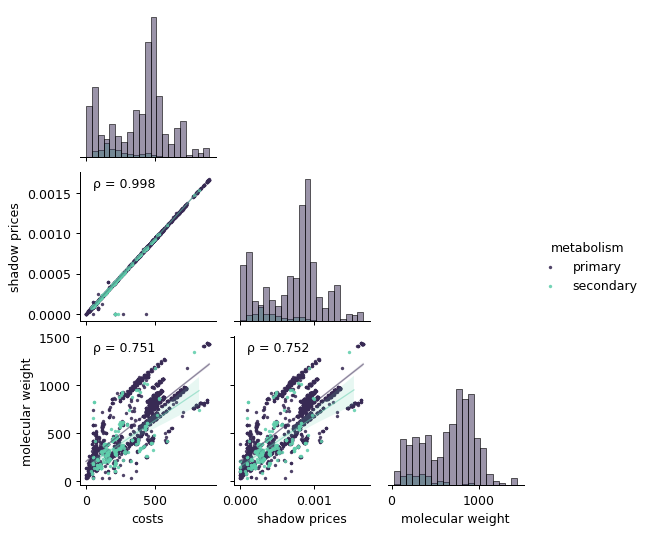

In [17]:
# correlation plot met. shadow prices, costs and MW
df_plot = (pd.read_excel(folder+'Costs_&_ShadowPrices_all_mets.xlsx',skiprows=1)
           .rename(columns={'Unnamed: 0':'metabolite','Unnamed: 1':'costs',0.6:'shadow prices'})
           .merge(pd.read_excel(folder+'Costs_vs_MWs.xlsx')[['metabolite','molecular weight']],
                  on='metabolite',how='left')
           [['metabolite','costs','shadow prices','molecular weight']]
          )
df_plot['metabolism'] = 'primary'
df_plot.loc[df_plot.metabolite.isin(df_test.explode("product_ids").product_ids),'metabolism'] = 'secondary'

import itertools
# correlations
cols = ['costs','shadow prices','molecular weight']
col_pairs = list(itertools.product(df_plot[cols].columns, repeat=2))
f = stats.spearmanr

tmp = []
for i in [1,2,5]:
    r,p = f(df_plot[col_pairs[i][0]],df_plot[col_pairs[i][1]])
    print(r,p)
    tmp.append([col_pairs[i][0],col_pairs[i][1],r,p])
pd.DataFrame(tmp,columns=['c1','c2','r','p'])
print(tmp)

# multiplot
def corrfunc(x, y, ax=None, hue=None,**kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = stats.spearmanr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.3f}', xy=(.1, .9), xycoords=ax.transAxes)
    
g = sns.pairplot(df_plot, hue="metabolism", palette=pal22, 
                 diag_kind="hist", height=2, corner=True,
                 kind="reg",
                 #plot_kws=dict(), #plot_kws={'s':3}
                 plot_kws={'scatter_kws':{'s':3},
                           'line_kws':{'linewidth':'1', 'alpha':0.5}}
                )
g.map_lower(corrfunc)
plt.show()


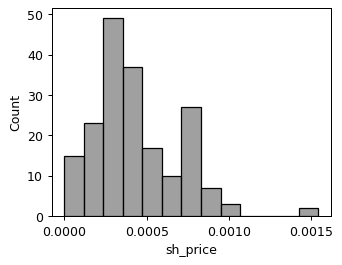

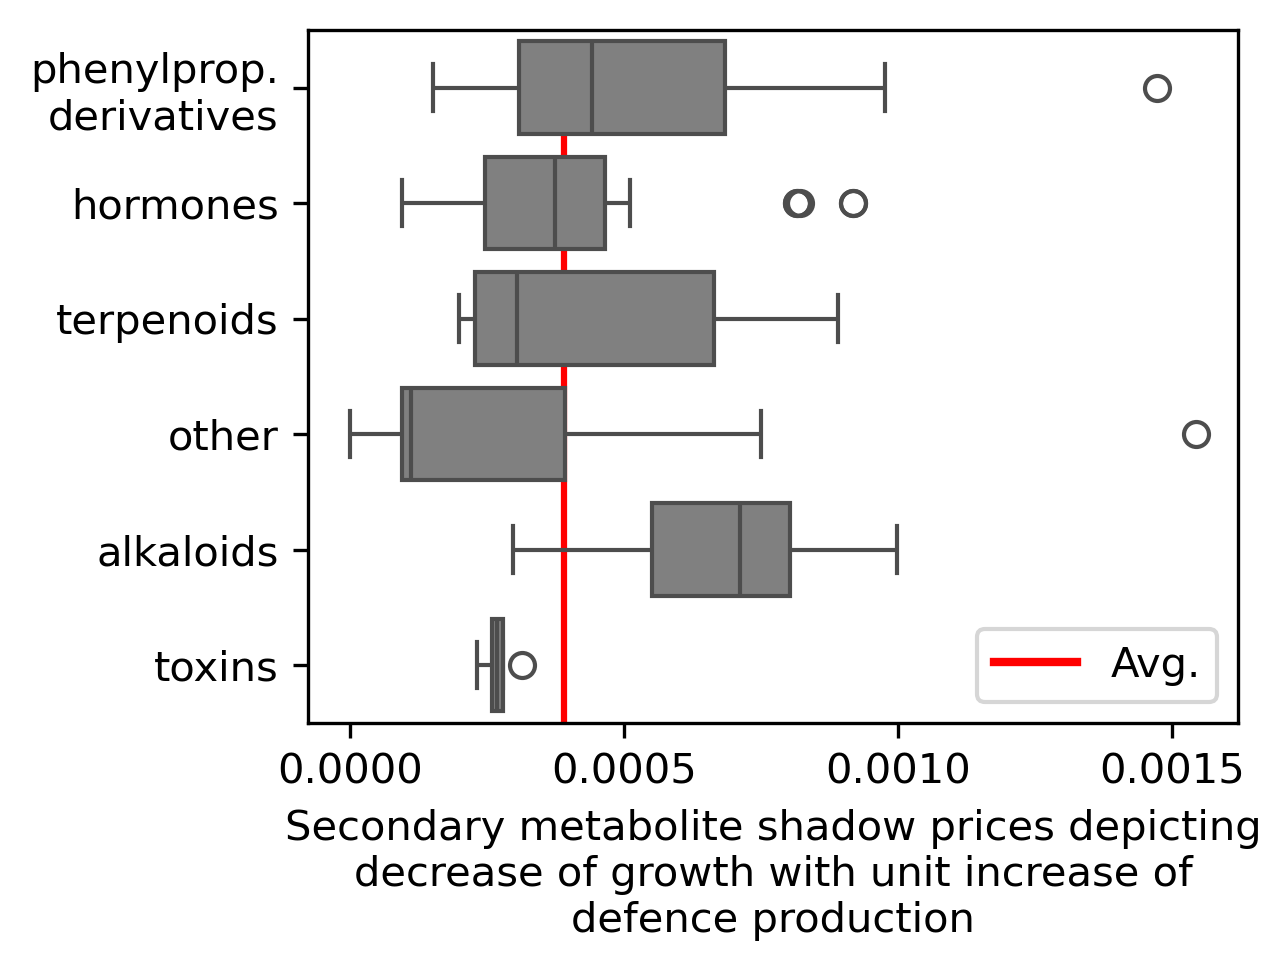

0.000389629392837822


In [18]:
# load data
df_plot = (pd.read_excel(folder+'ShadowPrices.xlsx',sheet_name='ShadowPrices')
         .set_index('metabolite')
         .unstack()
         .reset_index()
         .rename(columns={'level_0':'fopt',0:'sh_price'})
         .replace({'metabolite':{'campol[c]':'Campesterol[r]'}})
         .merge(df_test.explode('product_ids'),
           left_on='metabolite', right_on='product_ids', how='left')
         .query('type=="2nd"')
         .query('fopt==0.6')
         .replace({'class':{'phenylpropanoid derivatives':'phenylprop.\nderivatives'}})
        )

# plot hist
mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))
sns.histplot(data=df_plot,
            x='sh_price',
            color='grey')
plt.locator_params(nbins=6)
plt.show()

# plot class specific
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.boxplot(data=df_plot,
            x='sh_price',y='class',
            color='grey',order=order
           )
plt.xlabel('Secondary metabolite shadow prices depicting\ndecrease of growth with unit increase of\ndefence production')
plt.ylabel('')
#plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=6)

# add median line 
plt.plot((df_plot.sh_price.median(),df_plot.sh_price.median()),(0,100),'r',zorder=0)
plt.ylim(5.5,-0.5)

# add legend
custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Avg.'],loc=0)

plt.show()

print(df_plot.sh_price.median())

In [19]:
# alkaloids for text
print(df_plot[df_plot['class']=="alkaloids"].sh_price.median())
print(df_plot[df_plot['class']=="alkaloids"].sh_price.median()/
      df_plot.sh_price.median())

# stats
print(stats.ranksums(df_plot[df_plot['class']=="alkaloids"].sh_price.dropna(),
               df_plot[df_plot['class']!="alkaloids"].sh_price.dropna(),
     ))

0.000710389596031468
1.823244367827142
RanksumsResult(statistic=np.float64(3.0700866259179067), pvalue=np.float64(0.002139966927334613))


0.000833508940332806


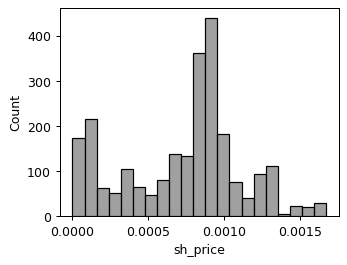

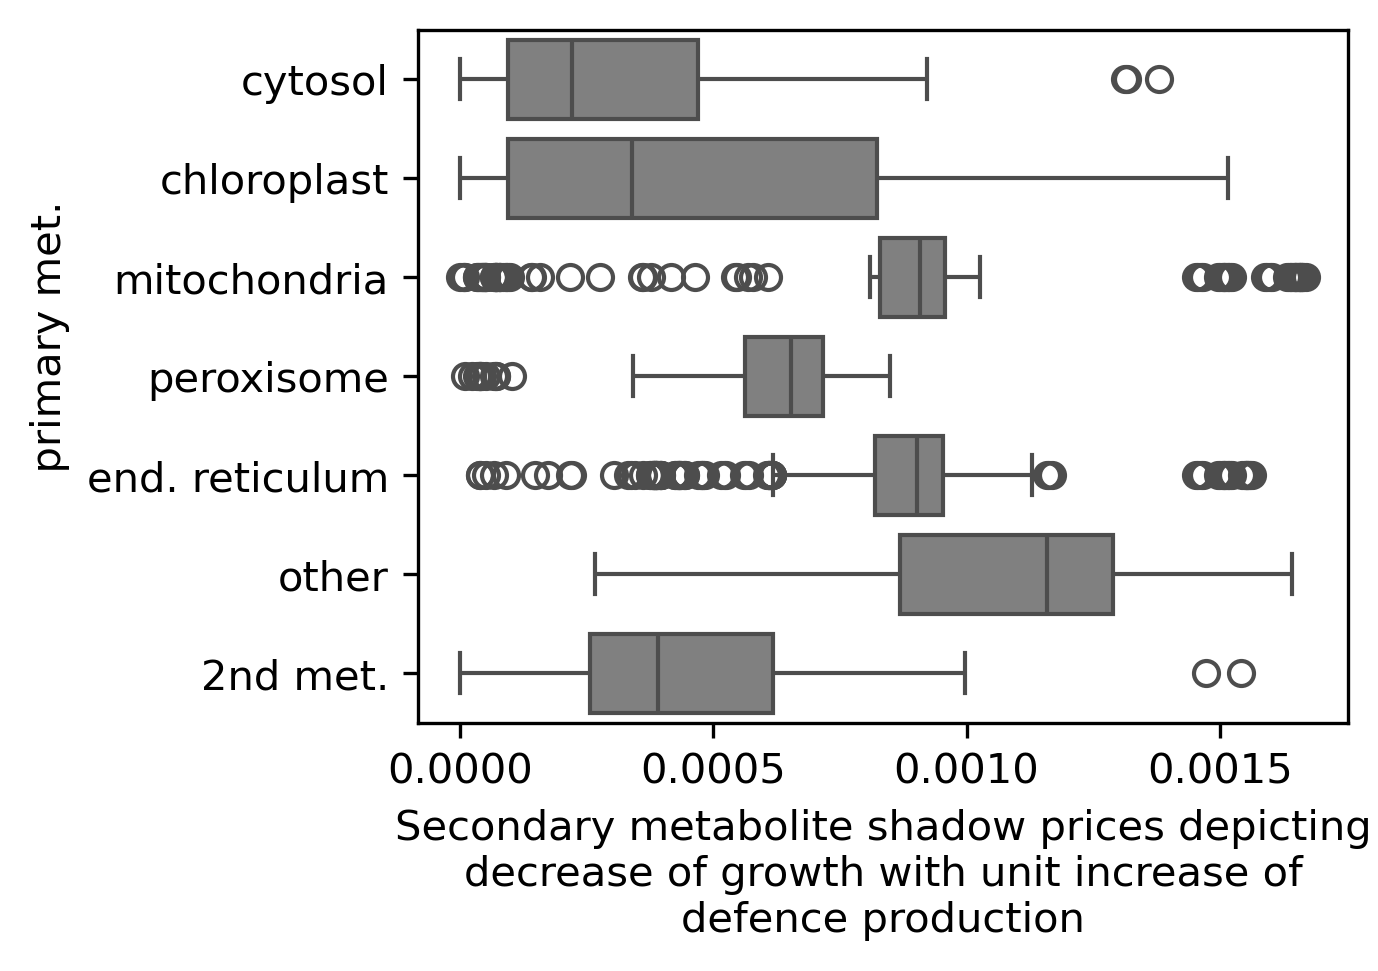

In [20]:
df_tmp = (pd.read_excel(folder+'Costs_&_ShadowPrices_all_mets.xlsx',skiprows=1)
         .rename(columns={'Unnamed: 0':'metabolite','Unnamed: 1':'Costs'})
         .set_index('metabolite')
         .unstack()
         .reset_index()
         .rename(columns={'level_0':'fopt',0:'sh_price'})
         .query('fopt==0.6')
         .query('~metabolite.isin(@df_test.explode("product_ids").product_ids)')
        )
df_tmp['type'] = 'primary'
prim_avg = df_tmp.sh_price.median()
print(prim_avg)

# plot hist
mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))
sns.histplot(data=df_tmp,
            x='sh_price',
            color='grey')
plt.locator_params(nbins=6)
plt.show()

# split across compartment
# translate to names
dic ={'c': 'cytosol', 
      'r': 'end. reticulum',
      'rm': 'end. reticulum', # membrane
      'm': 'mitochondria',
      'mm': 'mitochondria', # membrane
      'imm': 'mitochondria', # intermembrane sapce mito
      'h': 'chloroplast', 
      'hm': 'chloroplast', # membrane
      'ohm': 'chloroplast', # outer ch. membrane
      'x': 'peroxisome', 
      'cut':'other',
    'g':'other',
    'l':'other',
    'ob':'other',
    'pg':'other',
    'pm':'other',
}

df_tmp['type'] = (df_tmp
                  .metabolite.apply(lambda x: x.split('[')[1].strip(']'))
                  .map(dic)
                 )
df_tmp.type.value_counts()

# merge to single figure
df_plot['type'] = '2nd met.'
df_plot = pd.concat([df_tmp,df_plot[['fopt','metabolite','sh_price','type']]],ignore_index=True)

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,3))
sns.boxplot(data=df_plot,
            x='sh_price',y='type',
            color='grey', order=['cytosol','chloroplast','mitochondria','peroxisome','end. reticulum','other','2nd met.'] 
           )
plt.xlabel('Secondary metabolite shadow prices depicting\ndecrease of growth with unit increase of\ndefence production')
plt.ylabel('      primary met.')
#plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=6)
plt.show()

In [21]:
# text values
print(df_plot.groupby('type').sh_price.median())
tmp = df_plot.groupby('type').sh_price.median()
print(tmp.iloc[0]/tmp.iloc[2])
print(tmp.iloc[0]/tmp.iloc[1])

# stats
print(stats.ranksums(df_plot.query('type=="cytosol"')['sh_price'].dropna(),
               df_plot.query('type=="2nd met."')['sh_price'].dropna(),
              ))

# percentage of cytosolic and chloroplast reactions estimate
tmp = df_rxns.query('type=="core"').comp_model.apply(fix_strings_list).apply(flatten).explode().value_counts()
print(tmp.iloc[0:2].sum()/tmp.sum())


type
2nd met.          0.000390
chloroplast       0.000338
cytosol           0.000220
end. reticulum    0.000901
mitochondria      0.000908
other             0.001160
peroxisome        0.000654
Name: sh_price, dtype: float64
1.7721620144557504
1.1511992925317123
RanksumsResult(statistic=np.float64(-6.774195888027992), pvalue=np.float64(1.2510007859880047e-11))
0.7837837837837838
